# DTW

ロジット値でスコア取得してみる．

In [1]:
import os
import sys
import glob
import shutil
import numpy as np
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Goole Colab環境か判断
# ローカル環境とColabo環境の両方で動作させたい(そのうち使う予定)
moduleList = sys.modules
ENV_COLAB = False
if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")
if ENV_COLAB:
    print("Execute in google_colab")

Not google_colab


## モデル取得

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch
import torch.nn.functional as F

In [4]:
tokenizer = AutoTokenizer.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")

## 小説のテキストで確認

In [5]:
# 定数定義
file_path = 'data/cards/001044/files/edit/4880_ruby_13757.txt'
force = False
save_score=True

In [6]:
pd.read_csv(file_path).head()

,text
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...
2,いや、「仲がいい」くらいな言葉では言いあらわせません。
3,兄弟でもこれほど愛し合っている者はまずないでしょう。
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。


In [7]:
# 必要な情報を取得しておく
file_name = file_path.split('/')[-1]
file_dir = '/'.join(file_path.split('/')[:-2])
score_dir = f'{file_dir}/score'
score_path = f'{score_dir}/{file_name}'

print(f'\
        file_name:{file_name}\n\
        file_dir:{file_dir}\n\
        score_dir:{score_dir}\n\
        score_path:{score_path}')

        file_name:4880_ruby_13757.txt
        file_dir:data/cards/001044/files
        score_dir:data/cards/001044/files/score
        score_path:data/cards/001044/files/score/4880_ruby_13757.txt


In [8]:
# スコア取得関数
"""
Arg:
    text: text(one line)
Returns:
    max logit
    max prediction
"""
def get_score(text):
    # 0: NEUTRAL  -> 0
    # 1: NEGATIVE -> -1
    # 2: POSITIVE -> 1
    coef_array = [0, -1, 1]
    # text: 文字列型を想定
    batch = tokenizer(text, padding=True, return_tensors='pt')

    with torch.no_grad():
        output = model(**batch)
        prediction = F.softmax(output.logits, dim=1)
        label = torch.max(output.logits, dim=1)
        value = label.values.item()
        index = label.indices.item()
    logit_value = value * coef_array[index]
    pred_value = torch.max(prediction).item() * coef_array[index]
    return logit_value, pred_value

In [9]:
# 動作確認
logit, pred = get_score('私は幸せだ')
print(logit, pred)

3.3383617401123047 0.9841786026954651


In [10]:
# 先ほど取得した小説のテキストを使用してスコア取得
df = pd.read_csv(file_path)
logit_score, pred_score = [], []
for i, text in enumerate(tqdm(df['text'])):
    logit, pred = get_score(text)
    logit_score.append(logit)
    pred_score.append(pred)

df['logit_score'] = logit_score
df['pred_score'] = pred_score
df.head()

100%|██████████| 799/799 [00:17<00:00, 45.71it/s]


,text,logit_score,pred_score
0,ネルロとパトラッシュ――この二人はさびしい身の上同志でした。,1.140869,0.527404
1,ふたりともこの世に頼るものなく取り残されたひとりぼっち同志ですから、その仲のいいことは言うま...,0.590122,0.580862
2,いや、「仲がいい」くらいな言葉では言いあらわせません。,-0.679344,-0.510203
3,兄弟でもこれほど愛し合っている者はまずないでしょう。,-0.395741,-0.552090
4,ほんとにこれ以上の親しさはかんがえられないほどの間柄でした。,1.552843,0.794932


In [12]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [13]:
# 取得したスコア数が100になるように平均化
window_size = int(df.shape[0] / 5)
logit_score_mean = get_score_mean(df['logit_score'], window_size=window_size)
pred_score_mean = get_score_mean(df['pred_score'], window_size=window_size)
print(list(logit_score_mean))
print(list(pred_score_mean))

[-0.0510326124399713, -0.13347052337613496, -0.11421871119700137, -0.11028076802034797, -0.07060997300552872, -0.10958188894034931, -0.16756229140098738, -0.22191873483312954, -0.1491998776137454, -0.13535101683634632, -0.10887497326113144, -0.05878300561844928, -0.03508841204193403, -0.0035628946322315146, 0.011303253518710346, 0.030516848249255487, 0.033552417402747295, -0.02181663265768087, -0.045839398537042005, -0.004153831574901845, 0.012312843739611548, -0.02427333893266114, -0.016051624743443616, -0.042883845620185324, -0.09463896878860281, -0.13963581668505878, -0.20320136554586063, -0.20283205216785646, -0.18204646327960416, -0.2372685839545052, -0.2846930653044263, -0.28965523895227685, -0.27623609964202783, -0.27288186437678785, -0.19450623321833102, -0.1568570999698069, -0.1451559768251653, -0.10548091726670475, -0.14052389145084898, -0.21112139949446204, -0.2267288862253135, -0.27032922428546463, -0.3417420783226595, -0.31448564575340765, -0.2984840598589969, -0.303908921

In [14]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

In [15]:
# 規格化
logit_score_norm = score_normalize(logit_score_mean)
pred_score_norm = score_normalize(pred_score_mean)
print(list(logit_score_norm))
print(list(pred_score_norm))

[0.8890002307482032, 0.7808180960545181, 0.8060819839261226, 0.8112496924999446, 0.8633091302144936, 0.8121668218874852, 0.7360799385911834, 0.6647487267971438, 0.7601766812072213, 0.778350350396083, 0.8130944975934532, 0.8788294965648444, 0.909923585251682, 0.9512940873905038, 0.970802728783501, 0.9960164644238821, 1.0, 0.9273399584793339, 0.8958152138010228, 0.9505186089825546, 0.9721276001202763, 0.9241160566831258, 0.9349052989350269, 0.8996937451722665, 0.8317762101193755, 0.772727466590502, 0.6893112726252973, 0.6897959174828601, 0.7170725593974971, 0.6446053312850681, 0.5823708378230961, 0.5758590457137484, 0.5934687973419625, 0.5978705140659524, 0.70072177497736, 0.7501282138104141, 0.7654834364952932, 0.8175484705117056, 0.7715620583112313, 0.6789179211966127, 0.6584364313993477, 0.6012203084875731, 0.5075062040593975, 0.5432744449814589, 0.5642731056811726, 0.5571541344971902, 0.5192782129504487, 0.5647479609459886, 0.6385244049178274, 0.6358204114204921, 0.723777960073523, 0

2種類のスコアを比較

規格化すると，それほど違いはない．

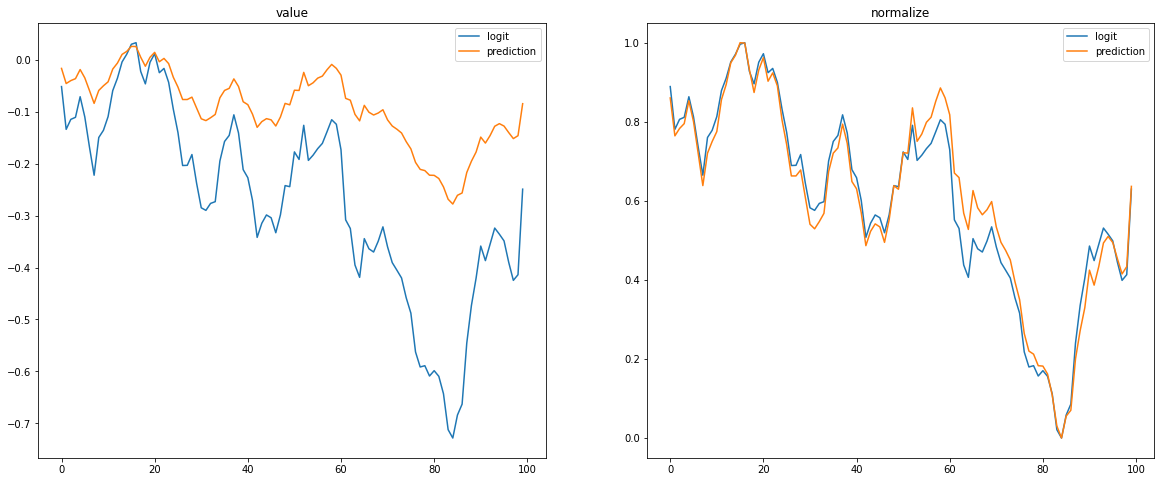

In [16]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('value')
ax1.plot(logit_score_mean, label='logit')
ax1.plot(pred_score_mean, label='prediction')
ax1.legend()

ax2.set_title('normalize')
ax2.plot(logit_score_norm, label='logit')
ax2.plot(pred_score_norm, label='prediction')
ax2.legend()

### DTWで比較

時系列データの評価としてDTWを使用する．

DTWについては以下の動画を参考にした．
- https://www.youtube.com/watch?v=9GdbMc4CEhE

こちらのWikiも参考になる．
- https://en.wikipedia.org/wiki/Dynamic_time_warping

In [17]:
# 動画で紹介されていたデータを使う
x = np.array([0, 2, 0, 1, 0, 0])
y = np.array([0, 0, 0.5, 2, 0, 1, 0])
x, y

(array([0, 2, 0, 1, 0, 0]), array([0. , 0. , 0.5, 2. , 0. , 1. , 0. ]))

この２つの系列データをDTWで計算した結果（動画参照）は，0.5となる．

以下，色々なライブラリで確認していく．
- 参考：https://forecastegy.com/posts/dynamic-time-warping-dtw-libraries-python-examples/

#### 自作関数

実践時系列解析に掲載されているサンプル

In [18]:
def distDTW(ts1, ts2):
    # 設定部分
    DTW = {}
    for i in range(len(ts1)):
        DTW[i, -1] = np.inf
    for i in range(len(ts2)):
        DTW[-1, i] = np.inf
    DTW[(-1, -1)] = 0

    # 1ステップずつ，最適な対応付を計算する部分
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[i-1, j], DTW[(i, j-1)], DTW[(i-1, j-1)])
    
    # 完全な経路が見つかったら関連する距離を返す
    return np.sqrt(DTW[len(ts1)-1, len(ts2)-1])


In [19]:
distDTW(x, y)

0.5

#### PyTS DTW

https://pyts.readthedocs.io/en/stable/generated/pyts.metrics.dtw.html

In [ ]:
!pip install pyts

In [21]:
from pyts.metrics import dtw as pyts_dtw
dist, path = pyts_dtw(x, y, dist='absolute', return_path=True)
dist

0.5

#### fastdtw

https://github.com/slaypni/fastdtw

In [ ]:
!pip install fastdtw

In [25]:
from fastdtw import fastdtw

In [26]:
dist, path = fastdtw(x, y)
dist

0.5

#### dtw-python

https://dynamictimewarping.github.io/python/

In [ ]:
!pip install dtw-python

In [27]:
from dtw import dtw as dtw_python
alignment = dtw_python(x, y, keep_internals=True)
alignment.distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



0.5

<AxesSubplot:>

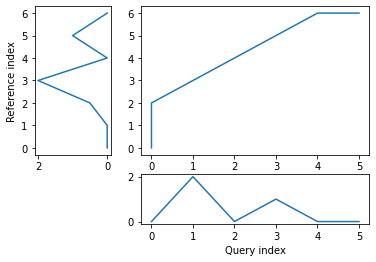

In [28]:
alignment.plot(type='threeway')

<AxesSubplot:xlabel='Index', ylabel='Query value'>

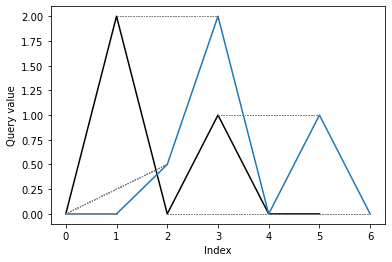

In [29]:
alignment.plot(type='twoway')

#### フランダースの犬を比較

PyTS DTWを使用する

In [30]:
from pyts.metrics import dtw

In [31]:
from pyts.metrics import dtw as pyts_dtw
dist, path = pyts_dtw(logit_score_norm, pred_score_norm, dist='absolute', return_path=True)
dist, path

(2.5101611595251185,
 array([[ 0,  1,  1,  2,  3,  4,  5,  6,  7,  8,  8,  9, 10, 11, 12, 13,
         14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 42, 43, 44,
         45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 58, 58,
         58, 58, 59, 60, 60, 61, 61, 61, 61, 61, 61, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 76, 77, 78, 79, 80,
         81, 82, 83, 84, 85, 86, 87, 87, 88, 89, 89, 90, 91, 92, 93, 94,
         95, 96, 97, 98, 99],
        [ 0,  1,  2,  3,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 12, 13,
         14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 44,
         45, 46, 47, 48, 49, 50, 51, 52, 53, 53, 53, 53, 54, 55, 56, 57,
         58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 71, 71,
         71, 71, 71, 71, 72, 73, 73, 74, 75, 76, 77, 78, 79, 80, 81, 81,


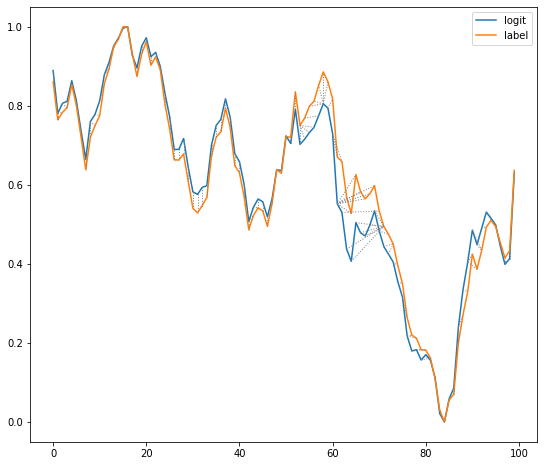

In [33]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1)

ax1.plot(logit_score_norm, label='logit')
ax1.plot(pred_score_norm, label='label')
ax1.legend()

for x0, x1 in zip(path[0], path[1]):
    ax1.plot([x0, x1], [logit_score_norm[x0], pred_score_norm[x1]], color='gray', linestyle='dotted', linewidth=1.0)